In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import pywt
import scipy
from skimage.restoration import denoise_wavelet

import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans


from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

from keras.utils.np_utils import to_categorical

from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

In [3]:
train_df=pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv',header=None)

In [4]:
train_x = np.array(train_df[train_df.columns[0:-1]], dtype=np.float32)
train_y = np.array(train_df[train_df.columns[-1]], dtype=np.float32)

test_x = np.array(test_df[test_df.columns[0:-1]], dtype=np.float32)
test_y = np.array(test_df[test_df.columns[-1]], dtype=np.float32)

In [5]:
test_y = tf.keras.utils.to_categorical(test_y, num_classes=5) 

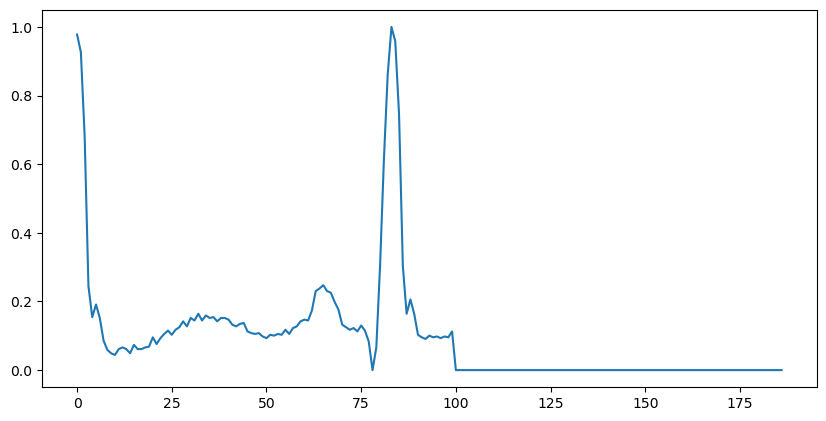

In [6]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(train_x[0])

In [7]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
cind=c.index.to_numpy()
cind

array([12677, 73472, 77710, 80624, 81769])

In [8]:
for i in range(len(train_x)):
    train_x[i] =  denoise_wavelet(train_x[i] ,method='BayesShrink', mode='soft',
                           rescale_sigma=True, wavelet='sym8', wavelet_levels=3)

for i in range(len(test_x)):
    test_x[i] =  denoise_wavelet(test_x[i] ,method='BayesShrink', mode='soft',
                           rescale_sigma=True, wavelet='sym8', wavelet_levels=3)

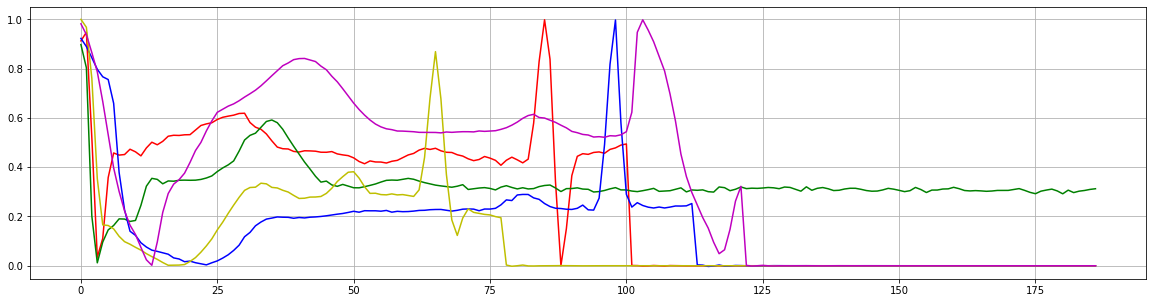

In [9]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.grid()
ax.plot(train_x[cind[0]], color="r")
ax.plot(train_x[cind[1]], color="g")
ax.plot(train_x[cind[2]], color="b")
ax.plot(train_x[cind[3]], color="y")
ax.plot(train_x[cind[4]], color="m")

plt.show()

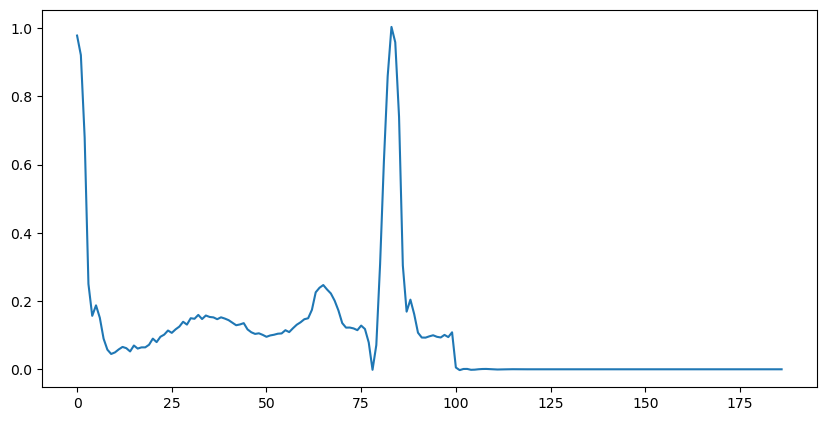

In [10]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(train_x[0])

In [11]:
def wpd(x):

    Xfeatures=np.zeros((len(x),8,29))

    for i in range(len(x)):
        wpack=pywt.WaveletPacket(data=x[i], wavelet='db4')
        Xfeatures[i]=np.vstack((wpack['aaa'].data,wpack['add'].data,wpack['dad'].data,wpack['dda'].data,
                                wpack['aad'].data,wpack['daa'].data,wpack['ada'].data,wpack['ddd'].data))
    
    return Xfeatures

In [12]:
Xfeatures=wpd(train_x)

In [13]:
Xtest_feats = wpd(test_x)

In [14]:
def scaling(x):
    sc=MinMaxScaler([0,1])
    x=x.reshape(len(x),len(x[0]),len(x[0][0]),1)
    scaled=np.zeros((len(x),len(x[0]),len(x[0][0]),1))
    #x=x.reshape(len(x),len(x[0]),len(x[0][0]))
    
    for i in range(len(x)):
        for j in range(8):
            sc.fit(x[i][j])
            scaled[i][j]=sc.transform(x[i][j])
            
    return scaled

In [15]:
Xfeat_scaled = scaling(Xfeatures)
Xfeat_scaled = Xfeat_scaled.reshape(-1,8,29)

In [16]:
Xtest_scaled = scaling(Xtest_feats)
Xtest_scaled = Xtest_scaled.reshape(-1,8,29)

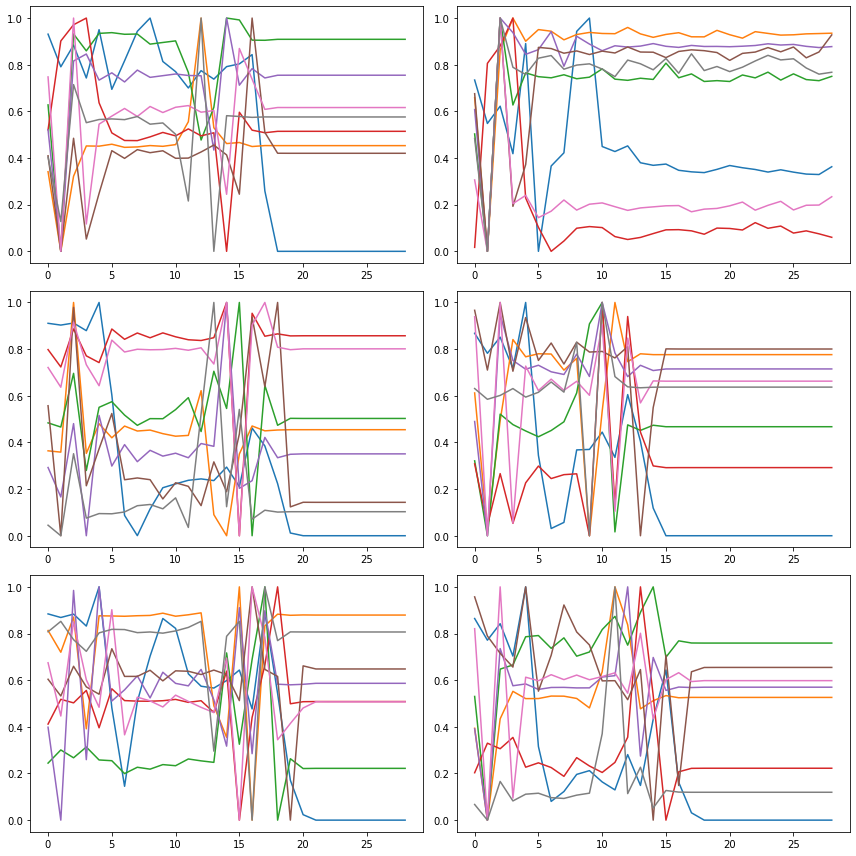

In [17]:
f, ((ax1,ax2),(ax3,ax4), (ax5,ax6))=plt.subplots(nrows=3, ncols=2, figsize=(12,12))


ax1.plot(Xfeat_scaled[cind[0]].T)
ax2.plot(Xfeat_scaled[cind[1]].T)
ax3.plot(Xfeat_scaled[cind[2]].T)
ax4.plot(Xfeat_scaled[cind[3]].T)
ax5.plot(Xfeat_scaled[cind[4]].T)
ax6.plot(Xfeat_scaled[0].T)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()

In [18]:
def wps(x):
    Xps= np.zeros((len(x),len(x[0]),len(x[0][0])))
    Xband_energy= np.zeros((len(x),len(x[0])))
        
    for i in range(len(x)):
        Xps[i]=np.square(np.abs(x[i]))        
        
    return Xps

In [19]:
Xscaled_power_spectrum=wps(Xfeat_scaled)

In [20]:
Xtest_scaled_power_spectrum= wps(Xtest_scaled)

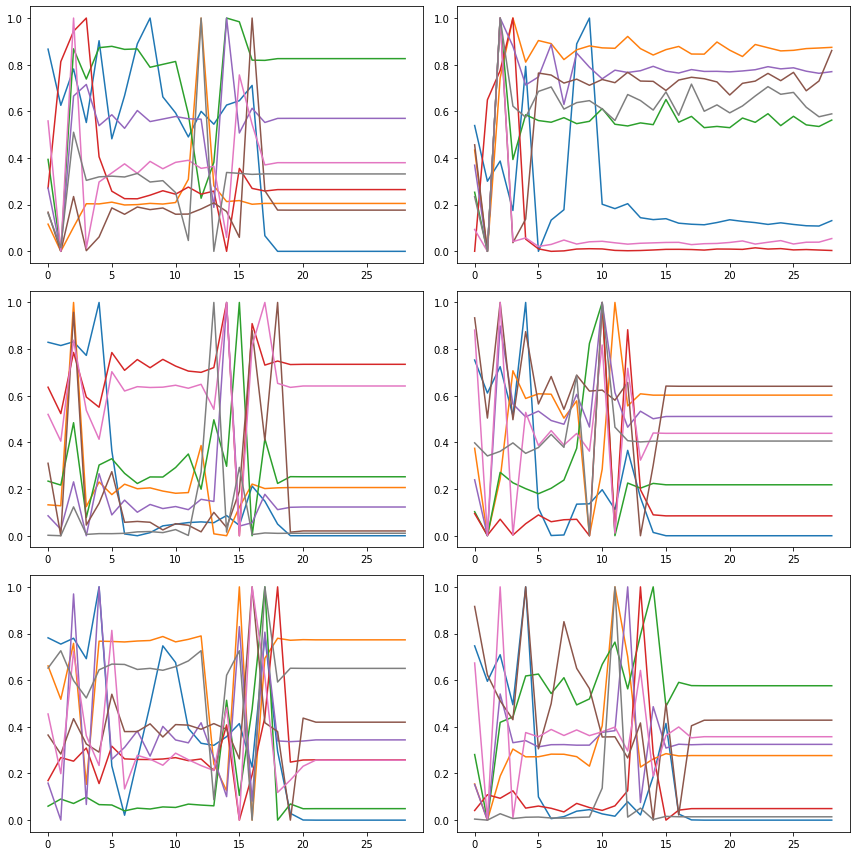

In [21]:
f, ((ax1,ax2),(ax3,ax4), (ax5,ax6))=plt.subplots(nrows=3, ncols=2, figsize=(12,12))


ax1.plot(Xscaled_power_spectrum[cind[0]].T)
ax2.plot(Xscaled_power_spectrum[cind[1]].T)
ax3.plot(Xscaled_power_spectrum[cind[2]].T)
ax4.plot(Xscaled_power_spectrum[cind[3]].T)
ax5.plot(Xscaled_power_spectrum[cind[4]].T)
ax6.plot(Xscaled_power_spectrum[0].T)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()


In [22]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled_power_spectrum, train_y, test_size=0.25, random_state=42, stratify=train_y)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5) 

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (65665, 8, 29)
Number transactions y_train dataset:  (65665, 5)
Number transactions X_test dataset:  (21889, 8, 29)
Number transactions y_test dataset:  (21889, 5)


In [23]:
X_tested = Xtest_scaled_power_spectrum

In [24]:
inputs=tf.keras.layers.Input(shape=(8,29,1))
x1=tf.keras.layers.Conv2D(32,(5,5),activation='relu', padding='SAME', name='conv2D_1')(inputs)
x1=tf.keras.layers.BatchNormalization(name='norm1')(x1)
x1=tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='SAME', name='conv2D_2')(x1)
x1=tf.keras.layers.BatchNormalization(name='norm2')(x1)
#x1=tf.keras.layers.MaxPool2D((2,2),name='pool1')(x1)
x1=tf.keras.layers.Dropout(0.1,name='drop1')(x1)

x2=tf.keras.layers.Conv2D(64,(3,3),activation='relu', padding='SAME', name='conv2D_3')(x1)
x2=tf.keras.layers.BatchNormalization(name='norm3')(x2)
x2=tf.keras.layers.Conv2D(64,(3,3),activation='relu', padding='SAME', name='conv2D_4')(x2)
x2=tf.keras.layers.BatchNormalization(name='norm4')(x2)
x2=tf.keras.layers.MaxPool2D((2,2),name='pool2')(x2)
x2=tf.keras.layers.Dropout(0.2,name='drop2')(x2)

x1=tf.keras.layers.Conv2D(64,(3,3),activation='relu', padding='SAME', name='conv2D_res1')(x1)
x1=tf.keras.layers.BatchNormalization(name='norm_res1')(x1)
x1=tf.keras.layers.MaxPool2D((2,2),name='pool_res1')(x1)

x2=tf.keras.layers.Add(name='add_1')([x1,x2])

x3=tf.keras.layers.Conv2D(128,(3,3),activation='relu', padding='SAME', name='conv2D_5')(x2)
x3=tf.keras.layers.BatchNormalization(name='norm5')(x3)
x3=tf.keras.layers.Conv2D(128,(3,3),activation='relu', padding='SAME', name='conv2D_6')(x3)
x3=tf.keras.layers.BatchNormalization(name='norm6')(x3)
x3=tf.keras.layers.Dropout(0.3,name='drop3')(x3)

x2=tf.keras.layers.Conv2D(128,(3,3),activation='relu', padding='SAME', name='conv2D_res2')(x2)
x2=tf.keras.layers.BatchNormalization(name='norm_res2')(x2)
#x2=tf.keras.layers.MaxPool1D(2,name='pool_res2')(x2)

x3=tf.keras.layers.Add(name='add_2')([x2,x3])

x4=tf.keras.layers.Flatten(name='flatten')(x3)
#model.add(rbflayer)
x4=Dense(512, activation='relu', name='dense_1')(x4)
x4=BatchNormalization()(x4)
x4=tf.keras.layers.Dropout(0.4,name='drop4')(x4)
x4=Dense(256, activation='relu', name='dense_2')(x4)
x4=BatchNormalization()(x4)
x4=Dense(128, activation='relu', name='dense_3')(x4)
#model1.add(rbflayer)
#x4=tf.keras.layers.Dropout(0.4,name='drop5')(x4)
x4=Dense(5, activation='softmax', name='output_layer')(x4)

outputs=x4

model=tf.keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 29, 1)]   0                                            
__________________________________________________________________________________________________
conv2D_1 (Conv2D)               (None, 8, 29, 32)    832         input_1[0][0]                    
__________________________________________________________________________________________________
norm1 (BatchNormalization)      (None, 8, 29, 32)    128         conv2D_1[0][0]                   
__________________________________________________________________________________________________
conv2D_2 (Conv2D)               (None, 8, 29, 32)    9248        norm1[0][0]                      
_______________________________________________________________________________________

In [26]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                 metrics=['accuracy'])

    # fit and predict
history=model.fit(X_train, y_train,
              batch_size=64,
              epochs=100,
                  steps_per_epoch=len(X_train)//64,
              validation_data=(X_test,y_test),
                 callbacks=[annealer])

Epoch 1/100
1026/1026 [==============================] - 9s 9ms/step - loss: 0.2474 - accuracy: 0.9277 - val_loss: 0.1566 - val_accuracy: 0.9509
Epoch 2/100
1026/1026 [==============================] - 9s 8ms/step - loss: 0.1418 - accuracy: 0.9592 - val_loss: 0.1161 - val_accuracy: 0.9675
Epoch 3/100
1026/1026 [==============================] - 9s 8ms/step - loss: 0.1107 - accuracy: 0.9680 - val_loss: 0.1488 - val_accuracy: 0.9622
Epoch 4/100
1026/1026 [==============================] - 9s 9ms/step - loss: 0.0949 - accuracy: 0.9718 - val_loss: 0.0968 - val_accuracy: 0.9715
Epoch 5/100
1026/1026 [==============================] - 9s 9ms/step - loss: 0.0833 - accuracy: 0.9755 - val_loss: 0.0811 - val_accuracy: 0.9766
Epoch 6/100
1026/1026 [==============================] - 9s 8ms/step - loss: 0.0731 - accuracy: 0.9779 - val_loss: 0.0806 - val_accuracy: 0.9776
Epoch 7/100
1026/1026 [==============================] - 9s 8ms/step - loss: 0.0666 - accuracy: 0.9797 - val_loss: 0.0742 - val_ac

1026/1026 [==============================] - 9s 8ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.1203 - val_accuracy: 0.9839
Epoch 58/100
1026/1026 [==============================] - 9s 8ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1200 - val_accuracy: 0.9840
Epoch 59/100
1026/1026 [==============================] - 9s 8ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1170 - val_accuracy: 0.9839
Epoch 60/100
1026/1026 [==============================] - 9s 9ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.1196 - val_accuracy: 0.9840
Epoch 61/100
1026/1026 [==============================] - 9s 8ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1207 - val_accuracy: 0.9839
Epoch 62/100
1026/1026 [==============================] - 9s 9ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1210 - val_accuracy: 0.9839
Epoch 63/100
1026/1026 [==============================] - 9s 9ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.1237 - val_accuracy

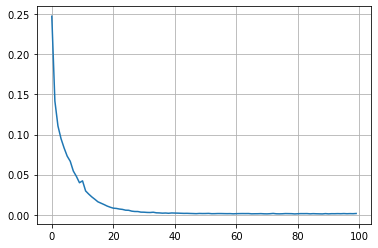

In [27]:
plt.grid()
plt.plot(history.history['loss'])

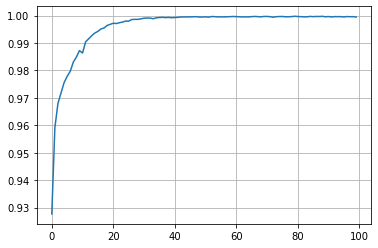

In [28]:
plt.grid()
plt.plot(history.history['accuracy'])

In [30]:
ypred = model.predict(X_tested)

for i in range(len(ypred)):
    ind=np.argmax(ypred[i])
    for j in range(5):
        if j==ind:
            ypred[i][j]=1.
        else:
            ypred[i][j]=0.
            


target_names = ['class 0', 'class 1', 'class 2',  'class 3',  'class 4']
print(classification_report(test_y, ypred, target_names=target_names, zero_division='warn'))

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99     18118
     class 1       0.92      0.75      0.83       556
     class 2       0.96      0.95      0.95      1448
     class 3       0.84      0.76      0.80       162
     class 4       0.99      0.98      0.98      1608

   micro avg       0.98      0.98      0.98     21892
   macro avg       0.94      0.89      0.91     21892
weighted avg       0.98      0.98      0.98     21892
 samples avg       0.98      0.98      0.98     21892



In [31]:
model.evaluate(X_tested, test_y)

685/685 [==============================] - 2s 3ms/step - loss: 0.1369 - accuracy: 0.9834


[0.13686919212341309, 0.9833729267120361]